In [2]:
# libraries required for data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# libraries required for data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# libraries required for ML
import pandas as pd
from statsmodels.tsa.seasonal import STL, seasonal_decompose
import matplotlib.pyplot as plt

Reference

[Time Series Anomaly Detection](https://arxiv.org/pdf/1708.03665.pdf)

[Time Series LSTM](https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing#scrollTo=KTqY8r6_Zpev) from [this](https://www.youtube.com/watch?v=c0k-YLQGKjY) youtube video

# Data Import

In [104]:
column_mapping = {
    'relative_humidity': 'humidity',
    'pir_sensor': 'pir',
    'light_switch': 'light'
}

# read in csv files
df_original = pd.read_csv("smart_home_dataset.csv").rename(columns=column_mapping)
# no movement
anomaly1 = pd.read_csv("anomaly_1.csv").rename(columns=column_mapping)
# 3h no movement
anomaly2 = pd.read_csv("anomaly_2.csv").rename(columns=column_mapping)
# midnight move
anomaly3 = pd.read_csv("anomaly_3.csv").rename(columns=column_mapping)

In [105]:
df_original.describe()

,temperature,humidity,light,ultrasonic,pir,pressure
count,132480.000000,132480.000000,132480.000000,132480.000000,132480.000000,132480.000000
mean,27.532609,77.988678,0.208009,0.020833,0.057601,0.375272
std,2.378168,11.981098,0.405885,0.142827,0.232989,0.484195
min,23.000000,44.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,79.000000,0.000000,0.000000,0.000000,0.000000
75%,29.000000,89.000000,0.000000,0.000000,0.000000,1.000000
max,34.000000,100.000000,1.000000,1.000000,1.000000,1.000000


# Data Visualization

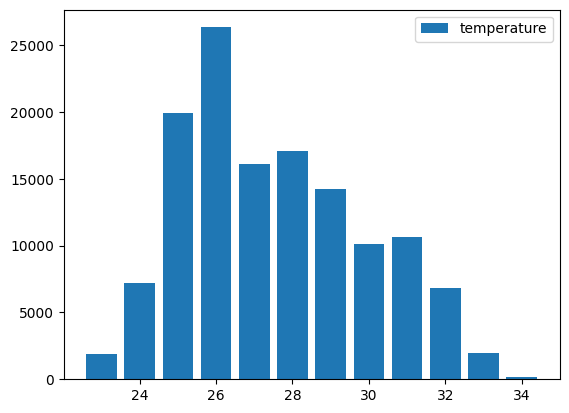

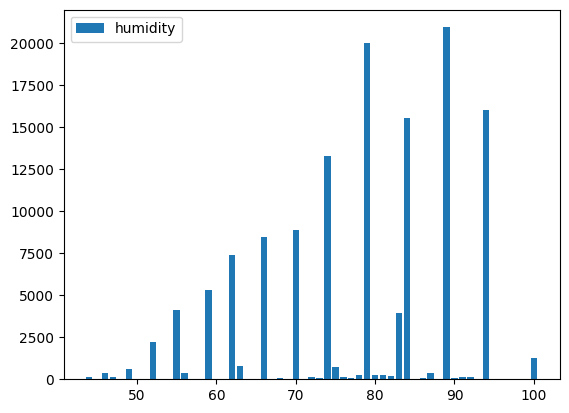

{}


In [135]:
curr_df = df_original.copy()
processed_curr_df = df_time_preprocess(curr_df.copy())

FEATURE_COLS = ['temperature', 'humidity']
# FEATURE_COLS = ['temperature', 'humidity', 'pir', 'light', 'ultrasonic', 'pressure']
FEATURE_COUNT = len(FEATURE_COLS)
WINDOW_SIZE = 60

multiplier = {}

for col in curr_df.columns:
    if col in FEATURE_COLS:
        col_freq = curr_df[col].value_counts()
        if len(col_freq) == 2:
            ratio = max(col_freq[0], col_freq[1]) / min(col_freq[0], col_freq[1])
            multiplier[col] = ratio
        plt.bar(col_freq.index, col_freq.values, label=col)
        plt.legend()
        plt.show()
        
        
print(multiplier)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

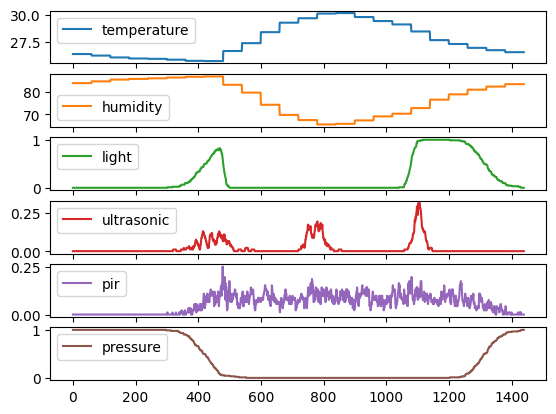

In [136]:
# 1: no movement, 2: 3h no movement, 3: midnight move
curr_df = df_original.copy()
curr_df = curr_df.drop(columns=['date_time']).groupby('time').mean().reset_index()

curr_df[[col for col in curr_df.columns if col not in ['hour_of_day', 'day_of_week']]].plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

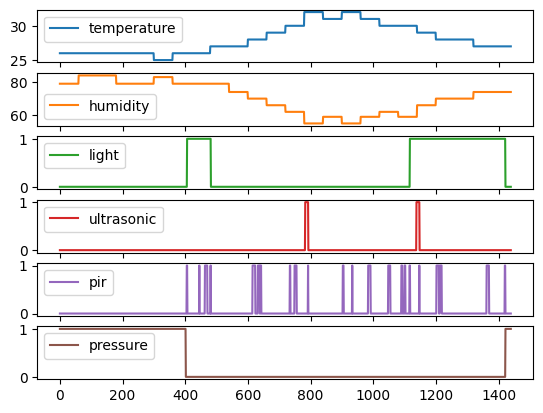

In [137]:
# 1: no movement, 2: 3h no movement, 3: midnight move
curr_df = anomaly2.copy()
curr_df = curr_df.drop(columns=['date_time']).groupby('time').mean().reset_index()

curr_df[[col for col in curr_df.columns if col not in ['hour_of_day', 'day_of_week']]].plot(subplots=True)

# Data Pre-processing Utility Functions

In [138]:
# pre-processing utility functions
def df_time_preprocess(df):
    # Create a temporary DataFrame to avoid modifying the input df
    temp_df = df.copy()

    # Convert to date_time object
    temp_df["date_time"] = pd.to_datetime(temp_df["date_time"])

    # Day of Week Column
    temp_df["date"] = temp_df["date_time"].dt.strftime("%Y-%m-%d")
    temp_df["day_of_week"] = temp_df["date_time"].dt.dayofweek.map(
        {
            0: "Monday",
            1: "Tuesday",
            2: "Wednesday",
            3: "Thursday",
            4: "Friday",
            5: "Saturday",
            6: "Sunday",
        }
    )
    temp_df["day_of_week"] = temp_df["date_time"].dt.dayofweek + 1

    # Hour of Day Column
    temp_df["hour_of_day"] = temp_df["date_time"].dt.strftime("%H")
    
    # Columns Cleanup
    temp_df["hour_of_day"] = pd.to_numeric(temp_df["hour_of_day"])
    temp_df["day_of_week"] = pd.to_numeric(temp_df["day_of_week"])
    temp_df = temp_df.drop(columns=["date_time", "date", 'time', 'day_of_week'])

    return temp_df

def window_slicing(df, feature_count, window_size = 60):
    df = df.to_numpy()
    X, y = [], []
    
    for i in range(len(df) - window_size):
        row = [r for r in df[i : i+window_size]]
        X.append(row)
        label = [df[i + window_size][j] for j in range(feature_count)]
        y.append(label)  
    
    return np.array(X), np.array(y)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
def data_preprocess(df, target_col):
    df[target_col] = scaler.fit_transform(df[[target_col]])
    return df

# Original Data

In [140]:
curr_df = df_original.copy()
curr_df = df_time_preprocess(curr_df)

non_feature_cols = [col for col in curr_df.columns if col not in FEATURE_COLS]
curr_df = curr_df[FEATURE_COLS + non_feature_cols]

feature_multipliers = {
#     'light': 4.009857358227995,
#     'ultrasonic': 590.7808219178082,
#     'pir': 57.61601085481683,
#     'pressure': 1.5978711888868844
    'ultrasonic': 10,
    'pir': 15,
    'hour_of_day': 10
}

standardized_curr_df = curr_df.copy()
for col in curr_df.columns:
    standardized_curr_df = data_preprocess(standardized_curr_df, col)
    if col in feature_multipliers:
        standardized_curr_df[col] = feature_multipliers[col] * standardized_curr_df[col]

standardized_curr_df = standardized_curr_df.drop(columns = ['light', 'ultrasonic', 'pir', 'pressure'])
# standardized_curr_df = standardized_curr_df.drop(columns = ['temperature', 'humidity'])

print('After Standardization:\n')
print(standardized_curr_df.describe())

After Standardization:

         temperature       humidity    hour_of_day
count  132480.000000  132480.000000  132480.000000
mean        0.412055       0.606941       5.000000
std         0.216197       0.213948       3.009658
min         0.000000       0.000000       0.000000
25%         0.272727       0.464286       2.500000
50%         0.363636       0.625000       5.000000
75%         0.545455       0.803571       7.500000
max         1.000000       1.000000      10.000000


In [141]:
X, y = window_slicing(standardized_curr_df, FEATURE_COUNT, WINDOW_SIZE)
print(X.shape, y.shape)

TRAIN_SIZE = 0.8
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

(132420, 60, 3) (132420, 2)


In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

OUTPUT_FEATURE_COUNT = len(FEATURE_COLS)
INPUT_FEATURE_COUNT = OUTPUT_FEATURE_COUNT + 1

model = Sequential()
model.add(LSTM(64, input_shape=(WINDOW_SIZE, INPUT_FEATURE_COUNT), return_sequences=False))
model.add(Dense(8, 'relu'))
model.add(Dense(OUTPUT_FEATURE_COUNT, activation='sigmoid'))

print(model.summary())
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17408     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 2)                 18        
                                                                 
Total params: 17946 (70.10 KB)
Trainable params: 17946 (70.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [143]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
3306/3311 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0414INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


3311/3311 [==============================] - 35s 10ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 3.1583e-04 - val_root_mean_squared_error: 0.0178
Epoch 2/10
3308/3311 [============================>.] - ETA: 0s - loss: 2.7104e-04 - root_mean_squared_error: 0.0165INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


3311/3311 [==============================] - 36s 11ms/step - loss: 2.7100e-04 - root_mean_squared_error: 0.0165 - val_loss: 2.7196e-04 - val_root_mean_squared_error: 0.0165
Epoch 3/10
3306/3311 [============================>.] - ETA: 0s - loss: 2.2411e-04 - root_mean_squared_error: 0.0150INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


3311/3311 [==============================] - 36s 11ms/step - loss: 2.2414e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.2921e-04 - val_root_mean_squared_error: 0.0151
Epoch 4/10
3311/3311 [==============================] - 35s 10ms/step - loss: 2.0202e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.4906e-04 - val_root_mean_squared_error: 0.0158
Epoch 5/10
3306/3311 [============================>.] - ETA: 0s - loss: 1.9077e-04 - root_mean_squared_error: 0.0138INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


3311/3311 [==============================] - 35s 11ms/step - loss: 1.9087e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.2329e-04 - val_root_mean_squared_error: 0.0149
Epoch 6/10
3311/3311 [==============================] - 35s 10ms/step - loss: 1.8213e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.2974e-04 - val_root_mean_squared_error: 0.0152
Epoch 7/10
3311/3311 [==============================] - ETA: 0s - loss: 1.7701e-04 - root_mean_squared_error: 0.0133INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


3311/3311 [==============================] - 36s 11ms/step - loss: 1.7701e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.9689e-04 - val_root_mean_squared_error: 0.0140
Epoch 8/10
3311/3311 [==============================] - 35s 11ms/step - loss: 1.7234e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.1657e-04 - val_root_mean_squared_error: 0.0147
Epoch 9/10
3311/3311 [==============================] - 34s 10ms/step - loss: 1.7053e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.3086e-04 - val_root_mean_squared_error: 0.0152
Epoch 10/10
3311/3311 [==============================] - 34s 10ms/step - loss: 1.6875e-04 - root_mean_squared_error: 0.0130 - val_loss: 3.0777e-04 - val_root_mean_squared_error: 0.0175


# Anomaly Dataset

44/44 [==============================] - 0s 3ms/step
Temperature_mse:  63.67
Humidity_mse:  2.81


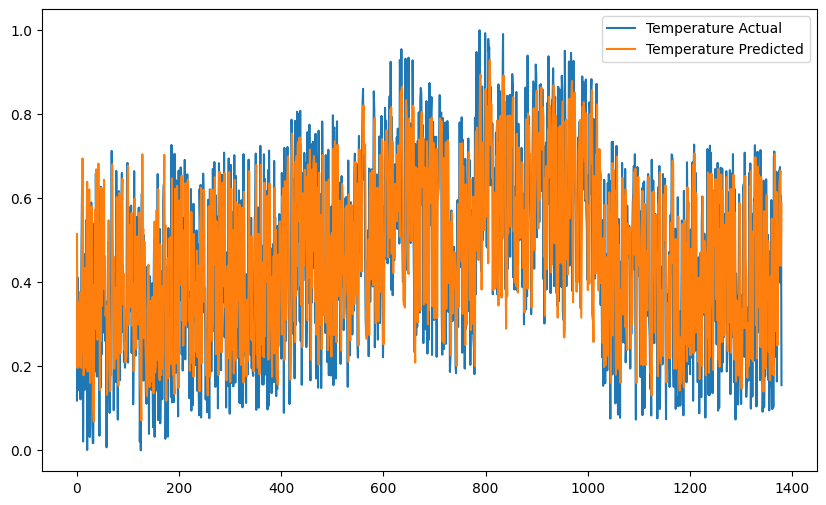

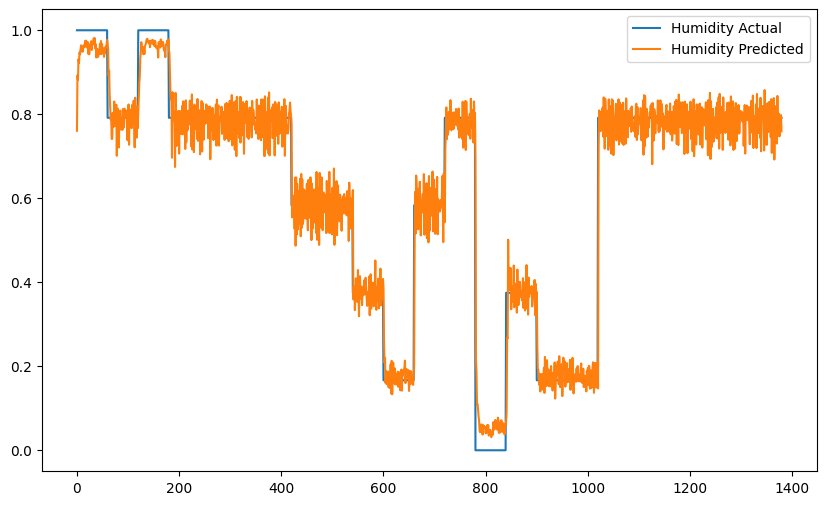

In [148]:
##### "1: no movement; 2: 3h no movement; 3: midnight movement "
# curr_df = anomaly3.copy()

num_chunks = len(df_original) // 1440
chunk_index = np.random.randint(0, num_chunks)
x = chunk_index * 1440
curr_df = df_original[x: x + 1440]

curr_df = df_time_preprocess(curr_df)

non_feature_cols = [col for col in curr_df.columns if col not in FEATURE_COLS]
curr_df = curr_df[FEATURE_COLS + non_feature_cols]
curr_df['temperature'] = curr_df['temperature'] + np.random.uniform(1, 10, size = len(curr_df))
# curr_df['humidity'] = curr_df['humidity'] + np.random.uniform(50, 100, size = len(curr_df))

standardized_curr_df = curr_df.copy()
for col in standardized_curr_df.columns:
    standardized_curr_df = data_preprocess(standardized_curr_df, col)

standardized_curr_df = standardized_curr_df.drop(columns = ['light', 'ultrasonic', 'pir', 'pressure'])
    
X, y = window_slicing(standardized_curr_df, FEATURE_COUNT, WINDOW_SIZE)

model1 = load_model('model1/')

model_pred = model1.predict(X)
mse_values = []

data_dict = {}
for idx, col in enumerate(FEATURE_COLS):
    data_dict[f'{col}_pred'] = model_pred[:, idx]
    data_dict[f'{col}_act'] = y[:, idx]
test_results = pd.DataFrame(data=data_dict)
# test_results['ultrasonic_pred'] = test_results['ultrasonic_pred'].apply(lambda x: 1 if x > 0.4 else x)

# modifying scale back to [0, 1]
# for col in feature_cols:
#     test_results[f'{col}_pred'] = test_results[f'{col}_pred'].apply(lambda x: 1 if x > 1 else x)
#     test_results[f'{col}_pred'] = test_results[f'{col}_pred'].apply(lambda x: 0 if x < 0 else x)
    
for col in FEATURE_COLS:
    mse = mean_squared_error(test_results[f'{col}_pred'], test_results[f'{col}_act'])
#     mse_values.append(mse)
    print(f'{col.capitalize()}_mse: {mse * 1000: .2f}')

# Plotting
for col in FEATURE_COLS:
    plt.figure(figsize=(10, 6))
    plt.plot(test_results[f'{col}_act'], label=f'{col.capitalize()} Actual')
    plt.plot(test_results[f'{col}_pred'], label=f'{col.capitalize()} Predicted')

    plt.legend()
    plt.show()

In [ ]:
# import numpy as np
# from keras.models import Model
# from keras.layers import Input, LSTM, Dense, concatenate
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# class MultivariateLSTMModel:
#     def __init__(self, seq_length, input_dim):
#         self.seq_length = seq_length
#         self.input_dim = input_dim
#         self.model = self.build_model()

#     def build_model(self):
#         input_data = Input(shape=(self.seq_length, self.input_dim), name='input_data')
#         lstm_output = LSTM(50, activation='relu')(input_data)
#         output = Dense(self.input_dim)(lstm_output)

#         model = Model(inputs=input_data, outputs=output)

#         model.compile(optimizer='adam', loss='mean_squared_error')

#         return model

#     def train(self, X_train, y_train, epochs=100, batch_size=32, verbose=1, early_stopping_patience=None):
#         best_val_loss = float('inf')
#         patience_counter = 0

#         for epoch in range(epochs):
#             print(f'Epoch {epoch + 1}/{epochs}')
#             self.model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=False)

#             if early_stopping_patience:
#                 val_loss = self.model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
#                 print(f'Validation Loss: {val_loss}')

#                 if val_loss < best_val_loss:
#                     best_val_loss = val_loss
#                     patience_counter = 0
#                 else:
#                     patience_counter += 1

#                 if patience_counter >= early_stopping_patience:
#                     print(f'Early stopping after {epoch + 1} epochs.')
#                     break
#     def predict(self, X_test):
#         return self.model.predict(X_test)